<h1 align="center">Data mining the Allen Brain Atlases with Python</h1>
<h3 align="center">by Alex Williams</h3>

###Summary:

This is a short tutorial covering some basic tools for *programmatically* accessing the [Allen Brain Atlases](http://www.brain-map.org/). Doing this *programmatically* means you are accessing the data automatically with code, rather than with direct user interaction (i.e. going to the [ABA webportal](http://www.brain-map.org/), and clicking on each experiment of interest). This is obviously advantageous if you want to consider the expression pattern of many genes at once, rather than a handful. The power of large-scale neuroanatomical analyses is exemplified by this recent paper: [(Ramsden et al., 2015)](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004032).

**We will use modules from the [standard python library](https://docs.python.org/2/library/) for this tutorial. But also check out our notebooks for using [Tortilla](http://nbviewer.ipython.org/github/ahwillia/ampneuro/blob/gh-pages/allen_brain_workshop/tortilla.ipynb) and Flotilla (soon to come) for your analysis.**

In [1]:
from __future__ import division
import urllib
import json
import numpy as np
import pylab as plt
import warnings
warnings.filterwarnings('ignore') # ignore annoying divide by zero warning
%matplotlib inline

#Accessing the [Connectivity Atlas](http://connectivity.brain-map.org/):

To see how this works, try going to the following link: 

This retrieves all experiments in which axonal projections were traced to the lateral entorhinal cortex (`ENTl`). We coded this with the option `[target_domain$eqENTl]` which specifies the target (post-synaptic) neuroanatomical structure (here, `$eq` means "equals"). The data is given to us in [json format](http://en.wikipedia.org/wiki/JSON), which we specified by typing in `query.json`.

The code below defines a [function](http://www.learnpython.org/en/Functions) that pulls all connectivity experiments that resulting in a projection to a target area of our choice.

In [2]:
base_url = 'http://api.brain-map.org/api/v2/data/query.json?' + \
           'criteria=service::mouse_connectivity_injection_structure'

def targ_data(targ):
    s = 0    # index for starting row
    done = False
    data = []
    
    # The Allen Institute doesn't give us everything at once,
    # we need to keep asking for more "rows" (experimental datasets)
    # until there are none left, we do this by passing the
    # [start_row$eq(s)] option, and keep incrementing s until there
    # are no rows left.
    while not done:
        paged_url = base_url+'[target_domain$eq'+targ+'][start_row$eq'+str(s)+']'
        new_data = json.loads(urllib.urlopen(paged_url).read())
        if new_data['num_rows'] == 0:
            done = True
        else:
            data += new_data['msg']
            s += new_data['num_rows']
    return data

### As an example, lets look at the medial entorhinal cortex.

In [3]:
# Pull data for all projections to medial entorhinal cortex
raw_data = targ_data('ENTm')

print type(raw_data) # we are given a list of experiments

<type 'list'>


### Looking through the data
Let's look at the first experiment in the list we retrieved. Each experiment is a [python dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries). What's nice about python dictionaries is that they can more or less be read like json data format. Both are pretty easy to read by eye.

In [4]:
# let's look at the first experiment (element #0 in the list)
print type(raw_data[0]) # It's a dictionary!
print raw_data[0] 

<type 'dict'>
{u'num-voxels': 2984, u'name': u'Slc17a6-IRES-Cre-2850', u'structure-name': u'Postsubiculum', u'transgenic-line': u'Slc17a6-IRES-Cre', u'gender': u'F', u'injection-volume': u'0.165434', u'structure-abbrev': u'POST', u'strain': u'B6.129', u'injection-coordinates': [9500, 2900, 8000], u'injection-structures': [{u'abbreviation': u'VISp', u'color': u'08858C', u'id': 385, u'name': u'Primary visual area'}, {u'abbreviation': u'POST', u'color': u'48C83C', u'id': 1037, u'name': u'Postsubiculum'}, {u'abbreviation': u'PRE', u'color': u'59B947', u'id': 1084, u'name': u'Presubiculum'}], u'sum': u'0.68568', u'structure-color': u'48C83C', u'structure-id': 1037, u'id': 167654019}


###Cool, so let's parse this out a bit more.
One of the first things we'd be interested in is the structure that *projects to* the medial entorhinal cortex. (We know that ENTm received projections in all experiments, but from a different source in each experiment.) We can do this by accessing the `'structure-name'` field in the dictionary

In [5]:
print raw_data[0]['structure-name']

Postsubiculum


In [6]:
## Here are some other things that might be interesting
print raw_data[0]['gender']                 # gender of the mouse
print raw_data[0]['sum']                    # total fluorescence in ENTm
print raw_data[0]['injection-coordinates']  # exactly where they injected tracer

F
0.68568
[9500, 2900, 8000]


### Lets make some plots

One thing we might be interested in is plotting the amount of fluorescence (a *rough* measure of projection strength). To do this let's define a [function](http://www.learnpython.org/en/Functions) that takes a list of source structures and plots the fluorescence for each experiment associated with those structures.

In [7]:
def plot_by_source(raw_data,source_names):
    n = len(source_names)
    for (xx,name) in enumerate(source_names):
        F = [] # list of fluorescences
        for experiment in raw_data:
            if experiment['structure-name'] == name:
                F.append(np.log(float(experiment['sum'])))
        plt.plot(1+xx+np.random.uniform(-0.2,0.2,len(F)),F,'ok')
    
    # Make the plot look nice
    frmt_names = [name.replace(' ','\n') for name in source_names]
    plt.xticks(range(1,n+1),frmt_names,fontsize=15,fontweight='bold')
    plt.ylabel('log avg F',fontsize=15,fontweight='bold')
    plt.xlim([0,n+1])

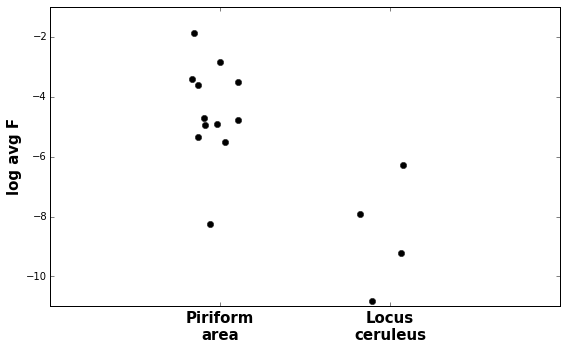

In [8]:
# Example: plot data strength of projections from Piriform area and Locus ceruleus
plt.figure(figsize=(8,5))
plot_by_source(raw_data,['Piriform area','Locus ceruleus'])
plt.tight_layout()
plt.show()

### Okay, great. But I like looking at raw data.

No problem! Let's write a function that produces a link to the original dataset on the Allen Brain Atlas website. Simply enter in the experiment ID and voila! The code below prints a url -- click on it to find the original experiment.

In [9]:
def search_atlas(query):
    return 'http://www.brain-map.org/search/index.html?query='+str(query)

print search_atlas(raw_data[0]['id'])

http://www.brain-map.org/search/index.html?query=167654019


If we want to be fancy, we can also use python to open up the atlas in a new window directly. Running the code block below should open up the appropriate page in a new tab

In [10]:
import webbrowser

def open_atlas(query):
    webbrowser.open(search_atlas(query))
    
open_atlas(raw_data[0]['id'])

#Accessing the [Grid Data](http://help.brain-map.org/display/api/Downloading+3-D+Expression+Grid+Data) for the Connectivity and ISH Atlases:

All gene expression and connectivity datasets have been registered to a common 3D coordinate system, providing us a convienent way to plot data from the primary experiments.

In [11]:
import zipfile
from StringIO import StringIO
from struct import unpack

def get_grid_data(expID):
    """Given an experiment ID, return the data in a 3D numpy array"""
    pagedUrl = 'http://api.brain-map.org/grid_data/download/'+str(expID)+'?include=density'
    expzipfile = zipfile.ZipFile(StringIO(urllib.urlopen(pagedUrl).read()))
    
    # Extract dimensions of 3D grid
    with expzipfile.open('density.mhd','r') as f:
        for line in f.readlines():
            if line[:7] == 'DimSize':
                dims = [int(d) for d in line[10:].split(' ')]
    dims.reverse()

    ## Read the density.raw file
    # There should be 4 characters '\xhh\xhh\xhh\xhh' for each 32-bit number
    with expzipfile.open('density.raw','r') as f:
        lines = f.readlines()
        
        # extract the density for each voxel
        s = ''.join(lines)  # turn file into one large string. What are the newlines for in the original file?
        density = unpack('<%df'%(len(s)/4),s)

    # map -1 to zero
    density = np.array(density)
    density[density < 0] *= 0

    # Make 3D arrays of density
    D = np.reshape(density,tuple(dims))

    return D

### How does this data look?

Let's take the first experiment from the list we downloaded previously and plot maximal projection along the coronal, saggital, and horizontal planes.

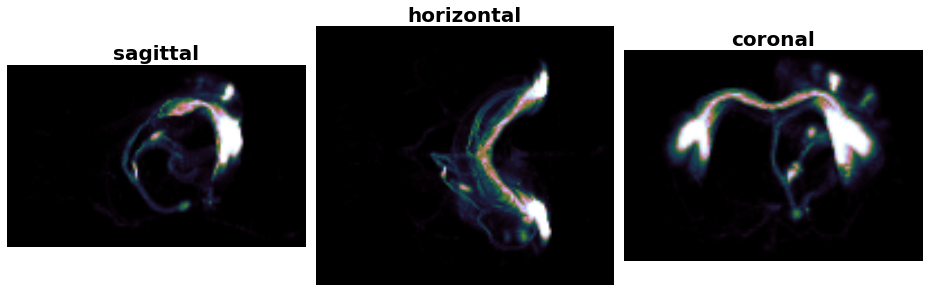

In [12]:
from matplotlib.pyplot import cm

def max_projection_plot(data):
    plt.figure(figsize=(13,10))
    for s,t in enumerate(['sagittal','horizontal','coronal']):
        ax = plt.subplot(1,3,s+1)
        if s == 2:
            ax.imshow(np.max(data,axis=s).T,cmap=cm.cubehelix)
        else:
            ax.imshow(np.max(data,axis=s),cmap=cm.cubehelix)
        plt.title(t,fontsize=20,fontweight='bold')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

max_projection_plot(get_grid_data(raw_data[0]['id']))

### A theme here is that making functions like "max_projection_plot" speeds up your analysis

Here, we plot the densities for three different experiments. This is kind of silly in this context, but this sort of thing could be useful if you wanted to compare three experiments with a similar injection site.

(115, 81, 133)


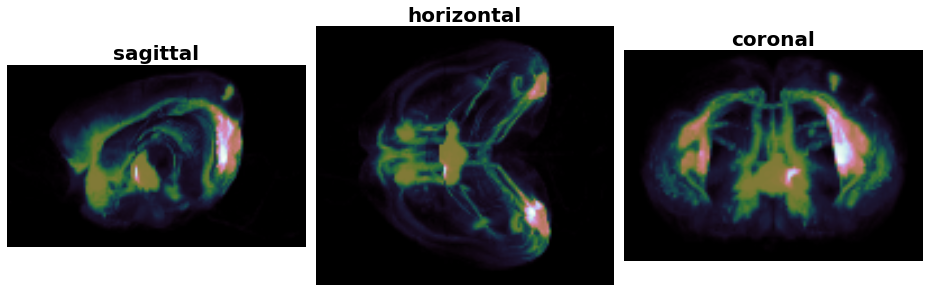

In [13]:
X = get_grid_data(raw_data[0]['id'])
X += get_grid_data(raw_data[1]['id'])
X += get_grid_data(raw_data[2]['id'])

print X.shape

max_projection_plot(X)

### Other Wacky Ideas

Let's do a principal components analysis of the connectivity data! Why not?

In [14]:
# This will take a while, since we are downloading a lot of data
X = []
for i in range(200):
    X.append(get_grid_data(raw_data[i]['id']).flatten())
X = np.array(X) # first 200 experiments in matrix form

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

model = PCA(n_components=3)
model.fit(X)

PCA(copy=True, n_components=3, whiten=False)

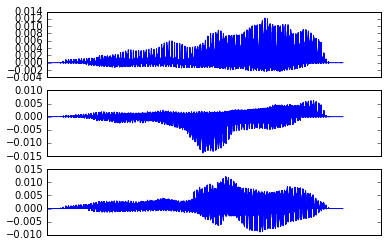

In [15]:
## Plot the top three principal components
plt.figure()
for s in range(3):
    plt.subplot(3,1,s+1)
    plt.plot(model.components_[s,:])
    plt.xticks([])
plt.show()

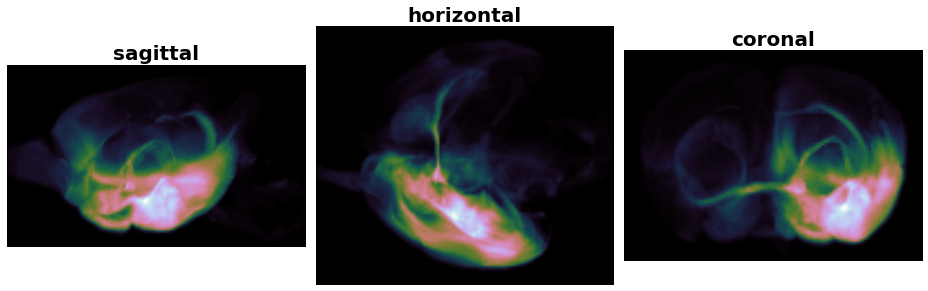

In [17]:
## Plot the top three principal components as images
dims = (115, 81, 133)
max_projection_plot(model.components_[0,:].reshape(dims))

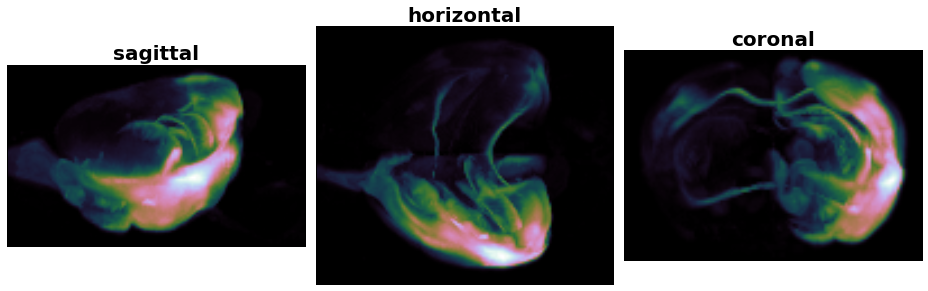

In [18]:
## Second Component
max_projection_plot(model.components_[1,:].reshape(dims))

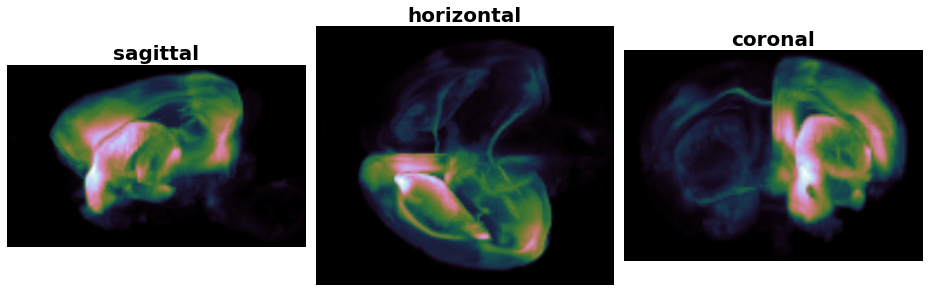

In [19]:
## Third Component
max_projection_plot(model.components_[2,:].reshape(dims))